This notebook is part of the deepcell-spots documentation: https://deepcell-spots.readthedocs.io/

# Multiplex FISH Analysis

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.feature import peak_local_max
from skimage.io import imread

from deepcell_spots.applications import Polaris
from deepcell.utils.plot_utils import create_rgb_image

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### Import images and barcodes

In [3]:
# Load images
idx_fov = 215
file_name = '/data/moffit_lab/raw_tiff_stacks/fov_%d.tif'%idx_fov
im_raw = imread(file_name)[:, :, 40:-40, 40:-40] # first dim is channel: 20 spot channel + 3 extra
im_raw = np.moveaxis(im_raw, (0,1,2,3), (3,0,1,2)) # (z, x, y, channel), z can be viewed as batch
im_raw_sub = im_raw[3:4, 1040:1540, 1040:1540, :] # crop a smaller image sample (1, 500, 500, 23)
spots_image = im_raw_sub[..., :20]
nuclear_image = im_raw_sub[..., 20:21]
membrane_image = im_raw_sub[..., 22:23]
mesmer_image = np.concatenate((nuclear_image, membrane_image), axis=-1)

In [4]:
# TODO: maybe save the processed csv?
# Load barcodes
def load_barcodes():
    df_barcodes = pd.read_csv('/data/Spots_barcode_Emily/dataset_2/barcodes.csv', index_col=0)
    df_barcodes.drop('id', axis=1, inplace=True)
    df_barcodes.index.name = 'code_name'
    df_barcodes = df_barcodes.reset_index()
    df_barcodes.index += 1
    return df_barcodes

df_barcodes = load_barcodes()
rounds = 10
channels = 2

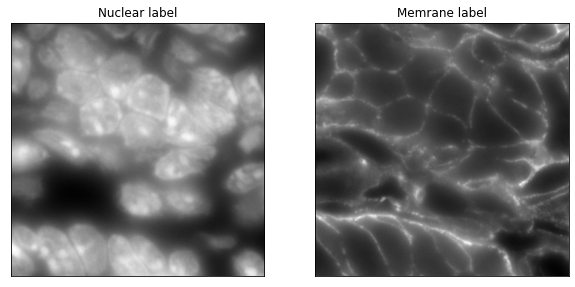

In [5]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(nuclear_image[0,...,0],cmap='gray')
ax[0].set_title('Nuclear label')
ax[1].imshow(membrane_image[0,...,0],cmap='gray')
ax[1].set_title('Memrane label')

for i in range(np.shape(ax)[0]):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

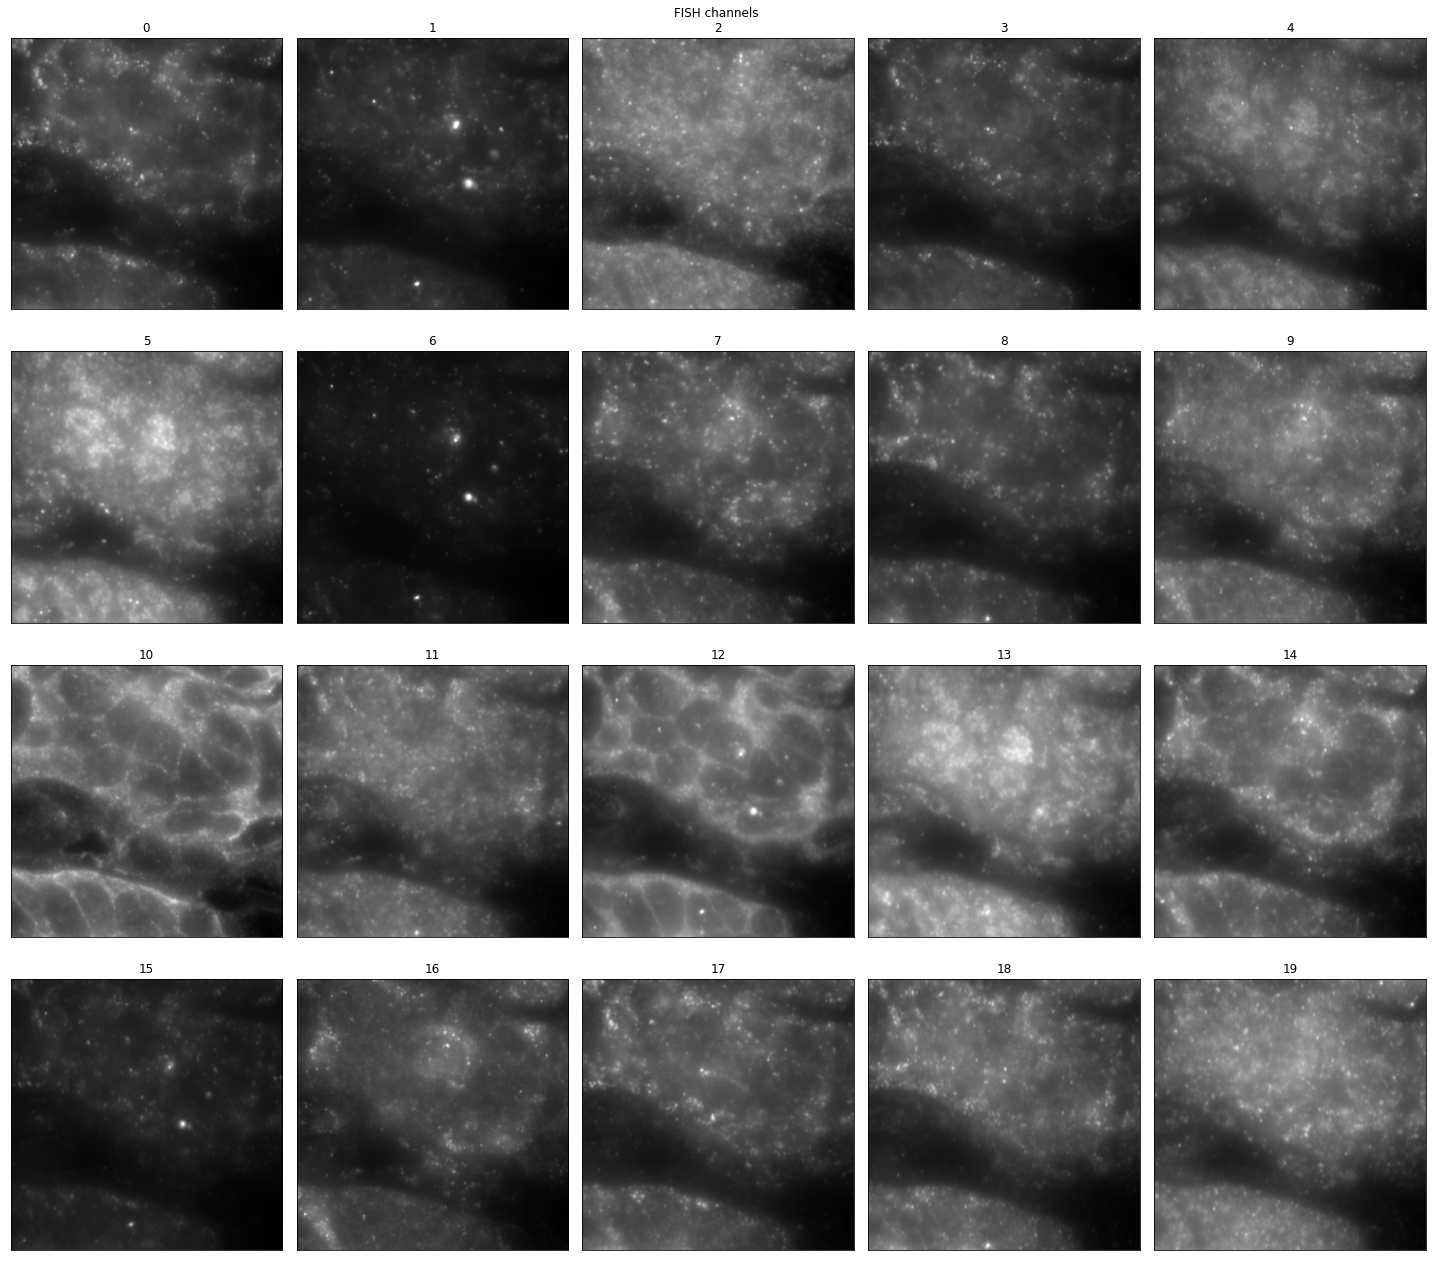

In [6]:
fig,ax = plt.subplots(4,5,figsize=(20, 18))

for idx, ax_d in enumerate(ax.flatten()):
    ax_d.imshow(spots_image[0,..., idx], cmap='gray')
    ax_d.set_title(idx)
    ax_d.set_xticks([])
    ax_d.set_yticks([])

plt.suptitle('FISH channels')
plt.tight_layout()

plt.show()

### mesmer segmentation

In [7]:
polaris_app = Polaris(image_type='multiplex', 
                      segmentation_type='mesmer',
                      decoding_kwargs={'rounds': rounds, 'channels': channels,
                                       'df_barcodes': df_barcodes})

2022-11-22 22:10:00.992369: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (34)
2022-11-22 22:10:00.992493: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-11-22 22:10:00.992743: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
spots_pred = polaris_app.predict(spots_image=spots_image,
                                 segmentation_image=mesmer_image,
                                 image_mpp=0.11, spots_clip=True, 
                                 spots_threshold=0.85,maxpool_extra_pixel_num=0)

/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0. Please use `footprint` instead.
  markers = h_maxima(image=maxima,


In [9]:
df_spots = spots_pred[0]
df_intensities = spots_pred[1]
segmentation_result = spots_pred[2]

In [10]:
df_spots

,x,y,batch_id,cell_id,probability,predicted_id,predicted_name
0,198,18,0,0,0.999979,4,Cps1
1,401,4,0,31,0.999917,6,Klk1
2,299,282,0,25,1.000000,5,Txndc5
3,202,291,0,0,0.999284,54,Stmn1
4,233,215,0,20,0.999967,4,Cps1
...,...,...,...,...,...,...,...
1871,385,5,0,31,0.990246,10,Slc12a2
1872,3,118,0,6,0.934491,53,Mki67
1873,35,320,0,7,0.892124,266,Background
1874,405,307,0,0,0.999860,266,Background


In [11]:
df_intensities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.989469,0.001488,0.777045,0.991447,0.004172,0.005669,0.000841,0.005659,0.019609,0.003129,0.019306,0.010427,0.009779,0.001311,0.669632,0.970973,0.010834,0.988954,0.011236,0.008119
1,0.000782,0.000774,0.016372,0.054698,0.159767,0.123109,0.899834,0.014734,0.002048,0.448233,0.006872,0.059896,0.164372,0.013769,0.007321,0.000051,0.990646,0.197881,0.020768,0.935381
2,0.000764,0.000582,0.008596,0.002220,0.004749,0.097340,0.002177,0.965878,0.002750,0.975360,0.016004,0.046585,0.012954,0.001794,0.973122,0.000090,0.989041,0.003535,0.020127,0.003854
3,0.988928,0.000104,0.007336,0.020120,0.092096,0.018123,0.049718,0.013331,0.004487,0.010725,0.011578,0.429875,0.051649,0.028495,0.977006,0.000686,0.044484,0.023980,0.971882,0.383781
4,0.983260,0.000375,0.070118,0.986303,0.019628,0.089608,0.000304,0.662878,0.915321,0.010965,0.486728,0.004050,0.042030,0.019065,0.002334,0.958685,0.634559,0.988894,0.251189,0.071666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,0.000477,0.001398,0.014362,0.000235,0.000913,0.001169,0.000228,0.851584,0.340898,0.015409,0.004693,0.000972,0.004433,0.001301,0.004629,0.000499,0.397331,0.442596,0.102449,0.348369
1872,0.002637,0.022679,0.032512,0.009490,0.010130,0.207580,0.000740,0.851431,0.005516,0.001148,0.057606,0.006625,0.011780,0.026880,0.000885,0.000354,0.006296,0.007179,0.005002,0.513556
1873,0.002896,0.000278,0.011936,0.012927,0.341649,0.850892,0.000222,0.000759,0.004143,0.030273,0.012647,0.014372,0.007671,0.076386,0.047773,0.001217,0.001508,0.012653,0.006676,0.305570
1874,0.001723,0.002641,0.000088,0.000217,0.000191,0.000091,0.002312,0.000978,0.000225,0.000151,0.000232,0.002751,0.001434,0.000091,0.000116,0.000465,0.850323,0.000161,0.000763,0.000205


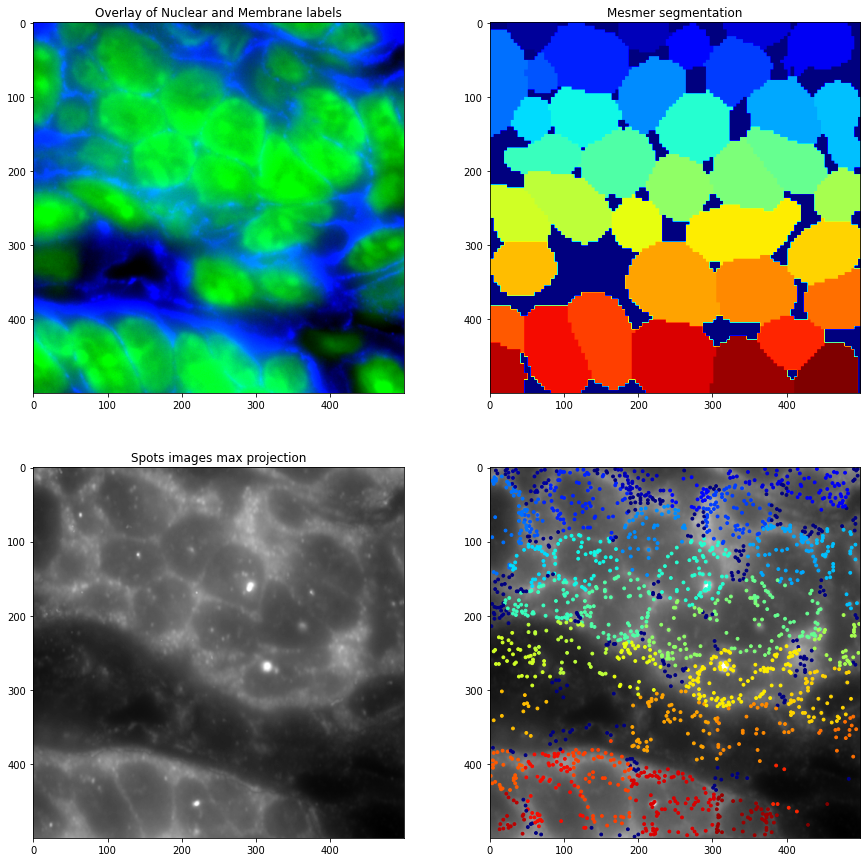

In [12]:
rgb_images = create_rgb_image(mesmer_image, channel_colors=['green', 'blue'])

fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0,0].imshow(rgb_images[0,...])
ax[0,0].set_title('Overlay of Nuclear and Membrane labels')
ax[0,1].imshow(segmentation_result[0,...,0],cmap='jet')
ax[0,1].set_title('Mesmer segmentation')
ax[1,0].imshow(np.max(spots_image, axis=-1)[0,...], cmap='gray')
ax[1,0].set_title('Spots images max projection')
ax[1,1].imshow(np.max(spots_image, axis=-1)[0,...], cmap='gray')
ax[1,1].scatter(df_spots.y, df_spots.x, c=df_spots.cell_id, cmap='jet', s=8)

### No segmentation

In [14]:
polaris_app = Polaris(image_type='multiplex', 
                      segmentation_type='no segmentation',
                      decoding_kwargs={'r': r, 'c': c, 'df_barcodes': df_barcodes})

/usr/local/lib/python3.8/dist-packages/deepcell_spots/applications/polaris.py:180: UserWarning: No segmentation application instantiated.
  warnings.warn('No segmentation application instantiated.')


In [15]:
spots_pred = polaris_app.predict(spots_image=spots_image,
                                 spots_clip=True, spots_threshold=0.85,
                                 maxpool_extra_pixel_num=0)

In [16]:
df_spots = spots_pred[0]
df_intensities = spots_pred[1]

In [17]:
df_spots

,x,y,batch_id,cell_id,probability,predicted_id,predicted_name
0,198,18,0,None,0.999977,4,Cps1
1,401,4,0,None,0.999917,6,Klk1
2,299,282,0,None,1.000000,5,Txndc5
3,202,291,0,None,0.999500,54,Stmn1
4,233,215,0,None,0.999953,4,Cps1
...,...,...,...,...,...,...,...
1871,385,5,0,None,0.987353,10,Slc12a2
1872,3,118,0,None,0.920225,53,Mki67
1873,35,320,0,None,0.882549,266,Background
1874,405,307,0,None,0.999824,266,Background


In [18]:
df_intensities

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.989469,0.001488,0.777045,0.991447,0.004172,0.005669,0.000841,0.005659,0.019609,0.003129,0.019306,0.010427,0.009779,0.001311,0.669632,0.970973,0.010834,0.988954,0.011236,0.008119
1,0.000782,0.000774,0.016372,0.054698,0.159767,0.123109,0.899834,0.014734,0.002048,0.448233,0.006872,0.059896,0.164372,0.013769,0.007321,0.000051,0.990646,0.197881,0.020768,0.935381
2,0.000764,0.000582,0.008596,0.002220,0.004749,0.097340,0.002177,0.965878,0.002750,0.975360,0.016004,0.046585,0.012954,0.001794,0.973122,0.000090,0.989041,0.003535,0.020127,0.003854
3,0.988928,0.000104,0.007336,0.020120,0.092096,0.018123,0.049718,0.013331,0.004487,0.010725,0.011578,0.429875,0.051649,0.028495,0.977006,0.000686,0.044484,0.023980,0.971882,0.383781
4,0.983260,0.000375,0.070118,0.986303,0.019628,0.089608,0.000304,0.662878,0.915321,0.010965,0.486728,0.004050,0.042030,0.019065,0.002334,0.958685,0.634559,0.988894,0.251189,0.071666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,0.000477,0.001398,0.014362,0.000235,0.000913,0.001169,0.000228,0.851584,0.340898,0.015409,0.004693,0.000972,0.004433,0.001301,0.004629,0.000499,0.397331,0.442596,0.102449,0.348369
1872,0.002637,0.022679,0.032512,0.009490,0.010130,0.207580,0.000740,0.851431,0.005516,0.001148,0.057606,0.006625,0.011780,0.026880,0.000885,0.000354,0.006296,0.007179,0.005002,0.513556
1873,0.002896,0.000278,0.011936,0.012927,0.341649,0.850892,0.000222,0.000759,0.004143,0.030273,0.012647,0.014372,0.007671,0.076386,0.047773,0.001217,0.001508,0.012653,0.006676,0.305570
1874,0.001723,0.002641,0.000088,0.000217,0.000191,0.000091,0.002312,0.000978,0.000225,0.000151,0.000232,0.002751,0.001434,0.000091,0.000116,0.000465,0.850323,0.000161,0.000763,0.000205


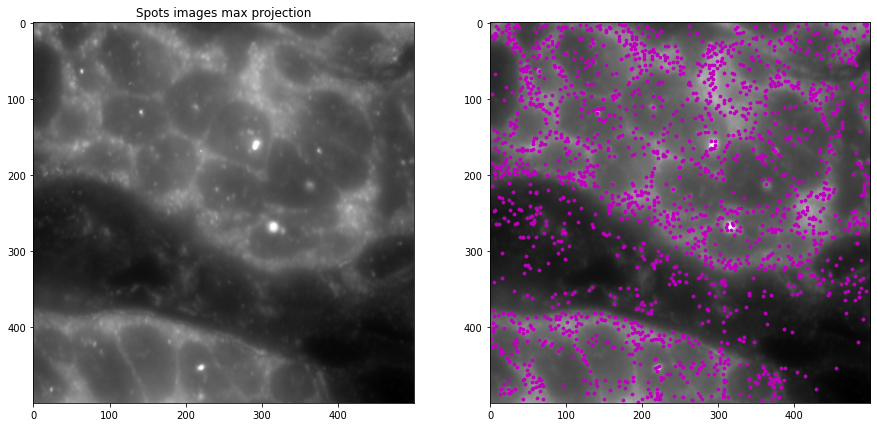

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(np.max(spots_image, axis=-1)[0,...], cmap='gray')
ax[0].set_title('Spots images max projection')
ax[1].imshow(np.max(spots_image, axis=-1)[0,...], cmap='gray')
ax[1].scatter(df_spots[df_spots.cell_id != 0].y, df_spots[df_spots.cell_id != 0].x, c='m', s=8)